In [1]:
import keras
#from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model,Model 
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Create files list ( Count total file numbers for training )
trainingset_path = r'//data/examples/may_the_4_be_with_u/where_am_i/train'
train_file_list = []
for root, dirs, files in os.walk(trainingset_path):
    for file in files:
        f = os.path.join(root,file)
        train_file_list.append(f)

In [3]:
print('total training data:',len(train_file_list))
print(train_file_list[1])

total training data: 2985
//data/examples/may_the_4_be_with_u/where_am_i/train/CALsuburb/image_0002.jpg


image_shape: (256, 256)


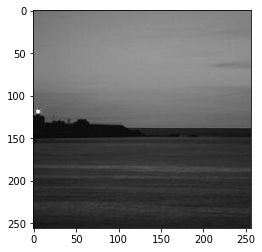

In [4]:
# Check image
img = cv2.imread(train_file_list[500], 0)
print('image_shape:',img.shape)#這裡可以看到我們透過上面的程式將圖片透過imread轉成陣列(numpy)的形式`,轉成數值後才能進行分析
plt.imshow(img, cmap="gray")#這裡則是將我們數值化後的值重新圖片化的結果

CALsuburb, 9
PARoffice, 7
bedroom, 12
coast, 10
forest, 4
highway, 14
industrial, 2
insidecity, 3
kitchen, 0
livingroom, 5
mountain, 8
opencountry, 6
store, 11
street, 1
tallbuilding, 13

In [5]:
# Class mapping by Kaggle rule
class_mapping = ['kitchen','street','industrial','insidecity','forest',
                 'livingroom','opencountry','PARoffice','mountain','CALsuburb'
                 ,'coast','store','bedroom','tallbuilding']

In [6]:
#Loading Image data from folder
image_size = 224 #設定圖片的像素大小
datagen_kaggle=ImageDataGenerator().flow_from_directory(trainingset_path,
                                                     target_size=(image_size,image_size),
                                                     classes=class_mapping,
                                                     batch_size=len(train_file_list),
                                                     shuffle=True)

Found 2825 images belonging to 14 classes.


In [7]:
datagen_kaggle_x,datagen_kaggle_y = next(datagen_kaggle)

In [8]:
# Create training & validation set
x_train,x_test,y_train,y_test = train_test_split(datagen_kaggle_x,datagen_kaggle_y,test_size=0.1)

In [9]:
# x_train.shape
# x_train[1]

In [10]:
batch_size = 32
num_classes = len(class_mapping)
epochs = 50
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_kaggle_trained_TL_ResNet50_model.h5'

In [11]:
# The data, shuffled and split between train and test sets:
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (2542, 224, 224, 3)
2542 train samples
283 test samples


In [12]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:
#Load InceptionNet V3(Google Net) model
#vgg16_model = keras.applications.vgg16.VGG16(include_top=False,input_shape=(image_size,image_size,3))
model = keras.applications.resnet50.ResNet50(include_top=False
                                             ,input_shape=(image_size,image_size,3)
                                             ,weights='imagenet'
                                            )

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [14]:
#odel.summary()

flatten_1 (Flatten)             (None, 2048)         0           avg_pool[0][0]                   
__________________________________________________________________________________________________
fc1000 (Dense)                  (None, 1000)         2049000     flatten_1[0][0]   

In [15]:
#攤平 feature map
last_layer = model.output
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(last_layer)
# add fully-connected & dropout layers
x = Dense(512, activation='relu',name='fc-1')(x)
#x = Dropout(0.5)(x)
x = Dense(256, activation='relu',name='fc-2')(x)
#x = Dropout(0.5)(x)
# a softmax layer for 4 classes
out = Dense(num_classes, activation='softmax',name='output_layer')(x)

#之前layer的trainable參數為False
for layer in model.layers[:-4]:
    layer.trainable = False
    
# creating the final model 
model = Model(input = model.input, output = out)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [16]:
# initiate Adam optimizer
opt = keras.optimizers.Adam()
#opt = keras.optimizers.Adadelta()

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [17]:
#input data normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

In [18]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    rotation_range=60,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False # randomly flip images
    ,zoom_range=0.4
    #zca_whitening=True, # PCA降维操作
    #zca_epsilon=1e-6 # PCA降維度參數
    )  

Using real-time data augmentation.


In [19]:
# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

In [20]:
# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=8, verbose=1)

In [21]:
# Fit the model on the batches generated by datagen.flow().
model_history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4,
                                    callbacks=[earlystop]
                               )

Epoch 1/50
80/80 [==============================] - 14s 172ms/step - loss: 1.1516 - acc: 0.6073 - val_loss: 3.3272 - val_acc: 0.0989
Epoch 2/50
80/80 [==============================] - 10s 124ms/step - loss: 0.7247 - acc: 0.7469 - val_loss: 3.7375 - val_acc: 0.0989
Epoch 3/50
80/80 [==============================] - 11s 132ms/step - loss: 0.5996 - acc: 0.7896 - val_loss: 3.6047 - val_acc: 0.0989
Epoch 4/50
80/80 [==============================] - 11s 132ms/step - loss: 0.5002 - acc: 0.8315 - val_loss: 3.7430 - val_acc: 0.0813
Epoch 5/50
80/80 [==============================] - 10s 131ms/step - loss: 0.5200 - acc: 0.8161 - val_loss: 4.2799 - val_acc: 0.0813
Epoch 6/50
80/80 [==============================] - 11s 131ms/step - loss: 0.4848 - acc: 0.8348 - val_loss: 4.7189 - val_acc: 0.0353
Epoch 7/50
80/80 [==============================] - 11s 132ms/step - loss: 0.4320 - acc: 0.8474 - val_loss: 4.6474 - val_acc: 0.0777
Epoch 8/50
80/80 [==============================] - 11s 132ms/step - 

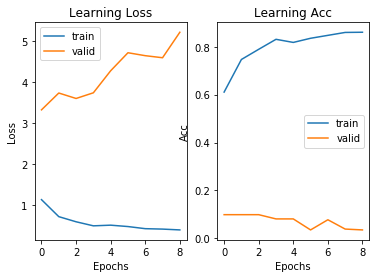

In [22]:
#draw the loss & acc

training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.figure(1)
plt.subplot(121)
plt.plot(training_loss, label="train")
plt.plot(val_loss, label="valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Loss")
plt.legend(loc='best')

plt.subplot(122)
plt.plot(training_acc, label="train")
plt.plot(val_acc, label="valid")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Acc")
plt.legend(loc='best')

plt.show()

In [23]:
#讀入 testing data 並組成 testing data set
testset_path = r'//data/examples/may_the_4_be_with_u/where_am_i/testset'
test_file_list = []
test_file_name = []
for root, dirs, files in os.walk(testset_path):
    for file in files:
        f = os.path.join(root,file)
        img = cv2.imread(f)
        img = cv2.resize(img,(image_size,image_size))/255. #圖片標準化
        img = np.expand_dims(img,axis=0)
        test_file_list.append(img)
        filename,_ = os.path.splitext(file)
        test_file_name.append(filename)

In [24]:
test_file_name = np.asarray(test_file_name)
test_file_name.shape

(1500,)

In [25]:
test_file_list[0].shape

(1, 224, 224, 3)

In [26]:
test_data = np.concatenate([x for x in test_file_list])
print(test_data.shape)

(1500, 224, 224, 3)


In [27]:
#model.summary()

In [28]:
# loading our save model
print("Loading trained model")
#model = load_model(model_path)
model.load_weights(model_path)
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Loading trained model


ValueError: Dimension 0 in both shapes must be equal, but are 2048 and 100352. Shapes are [2048,512] and [100352,1024]. for 'Assign_318' (op: 'Assign') with input shapes: [2048,512], [100352,1024].

In [ ]:
# 把測試資料丟到 model 預測
y_result = model.predict(test_data)
final_result = np.argmax(y_result,axis=1)
print(final_result.shape)
final_result

In [ ]:
#用 pandas 產出分類結果
submit = pd.DataFrame()
submit['id'] = test_file_name
submit['class'] = final_result
file_name = 'submission_ResNet50.csv'
#submit.to_csv(file_name,index=False)

In [ ]:
submit.head(5)